# Lung Cancer

## Get Radiomic Features from LIDC-IDRI

### Imports

In [ ]:
import pylidc as pl
from pylidc.utils import consensus
import SimpleITK as sitk
from radiomics import featureextractor
import pandas as pd
from imblearn.over_sampling import SMOTE
import statistics

### Get the dataset with all the features

In [ ]:

# Initialize the feature extractor
extractor = featureextractor.RadiomicsFeatureExtractor()

# Get the list of additional features from pl.annotation_feature_names
additional_features = pl.annotation_feature_names

# Query the LIDC-IDRI dataset for scans with annotations
scans_with_annotations = pl.query(pl.Scan).filter(pl.Scan.annotations.any()).all()

# Lists to store the extracted features and patient IDs
features_list = []

# Variable to create unique IDs for the nodules
nodule_id_counter = 1

#weights = {1: 0.18745, 2: 0.34375, 3: 0.65625, 4: 1.28125, 5: 2.53125}


# Iterating through all scans with annotations
for scan in scans_with_annotations:
    # Get the patient ID
    patient_id = scan.patient_id

    # Clusterize the annotations for the scan and retrieve all annotations
    nods = scan.cluster_annotations()

    # Iterating through all nodules of the patient
    for anns in nods:
        # Check if the current nodule has annotations
        if anns:
            # Convert consensus annotations into a mask
            cmask, _, _ = pl.utils.consensus(anns, clevel=0.5, pad=[(20, 20), (20, 20), (0, 0)])

            # Convert the pixel array to a SimpleITK image
            image = sitk.GetImageFromArray(cmask.astype(float))

            # Extract radiomic features using PyRadiomics
            features = extractor.execute(image, image, label=1)  # Use label 1 for the nodule

            # Add the patient ID to the features
            features['Patient_ID'] = patient_id

            # Add a unique ID for the nodule
            features['Nodule_ID'] = f'Nodule_{nodule_id_counter}'
            nodule_id_counter += 1

            def calculate_value(value):
                try:
                    return statistics.mode(value)
                except statistics.StatisticsError:
                    return np.mean(value)


            def  calculate_mean(value):
                return np.mean(value)
            
            subtlety_value = calculate_value([ann.subtlety for ann in anns])
            internalStructure_value = calculate_value([ann.internalStructure for ann in anns])
            calcification_value = calculate_value([ann.calcification for ann in anns])
            sphericity_value = calculate_value([ann.sphericity for ann in anns])
            margin_value = calculate_value([ann.margin for ann in anns])
            lobulation_value = calculate_value([ann.lobulation for ann in anns])
            spiculation_value = calculate_value([ann.spiculation for ann in anns])
            texture_value = calculate_value([ann.texture for ann in anns])
            malignancy_value = calculate_mean([ann.malignancy for ann in anns])
            
            #weighted_sum = sum(value*weights.get(value) for value in malignancy_value)
            #total_weight = sum(weights.get(value) for value in malignancy_value)
            #final_malignancy=weighted_sum/total_weight

            # Add the additional features to the features dictionary
            for feature_name in additional_features:
                features['subtlety'] = subtlety_value
                features['internalStructure'] = internalStructure_value
                features['sphericity'] = sphericity_value
                features['margin'] = margin_value
                features['lobulation'] = lobulation_value
                features['spiculation'] = spiculation_value
                features['texture'] = texture_value
                features['malignancy'] = malignancy_value # final_malignancy

            # Add the features to the list
            features_list.append(features)

        # Create a DataFrame to store the features
features_df = pd.DataFrame(features_list)

# Save the features to a CSV file
features_df.to_csv('radiomic_features.csv', index=False)


## Data Clean-up

In [149]:
#Read and print the features dataset
df = pd.read_csv('radiomic_features.csv')
df

,diagnostics_Versions_PyRadiomics,diagnostics_Versions_Numpy,diagnostics_Versions_SimpleITK,diagnostics_Versions_PyWavelet,diagnostics_Versions_Python,diagnostics_Configuration_Settings,diagnostics_Configuration_EnabledImageTypes,diagnostics_Image-original_Hash,diagnostics_Image-original_Dimensionality,diagnostics_Image-original_Spacing,...,Patient_ID,Nodule_ID,subtlety,internalStructure,sphericity,margin,lobulation,spiculation,texture,malignancy
0,v3.0.1,1.23.5,2.3.0-g277b7,1.4.1,3.11.5,"{'minimumROIDimensions': 2, 'minimumROISize': ...",{'Original': {}},966db6c8d814983bbfe7125907b2ae5008c7994e,3D,"(1.0, 1.0, 1.0)",...,LIDC-IDRI-0078,Nodule_1,4,1,4,4,2,2,5,3.75
1,v3.0.1,1.23.5,2.3.0-g277b7,1.4.1,3.11.5,"{'minimumROIDimensions': 2, 'minimumROISize': ...",{'Original': {}},d750f93365c734f6f1972e806b046bb1a203f47f,3D,"(1.0, 1.0, 1.0)",...,LIDC-IDRI-0078,Nodule_2,5,1,4,2,4,1,5,3.75
2,v3.0.1,1.23.5,2.3.0-g277b7,1.4.1,3.11.5,"{'minimumROIDimensions': 2, 'minimumROISize': ...",{'Original': {}},58d9ee5073ad7215556c1e295a67e9204a623b2d,3D,"(1.0, 1.0, 1.0)",...,LIDC-IDRI-0078,Nodule_3,4,1,5,5,1,1,5,1.00
3,v3.0.1,1.23.5,2.3.0-g277b7,1.4.1,3.11.5,"{'minimumROIDimensions': 2, 'minimumROISize': ...",{'Original': {}},312913e3e22bc6f2e6cffc8abd1120da5fa413fd,3D,"(1.0, 1.0, 1.0)",...,LIDC-IDRI-0078,Nodule_4,5,1,4,2,4,3,5,4.25
4,v3.0.1,1.23.5,2.3.0-g277b7,1.4.1,3.11.5,"{'minimumROIDimensions': 2, 'minimumROISize': ...",{'Original': {}},08706c40effcb9f7489dc9ce0139a265b8dc6048,3D,"(1.0, 1.0, 1.0)",...,LIDC-IDRI-0069,Nodule_5,3,1,5,5,5,5,5,3.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2646,v3.0.1,1.23.5,2.3.0-g277b7,1.4.1,3.11.5,"{'minimumROIDimensions': 2, 'minimumROISize': ...",{'Original': {}},db18dcbfdf1ebd1c1390db9dd1fbfd85cce4724b,3D,"(1.0, 1.0, 1.0)",...,LIDC-IDRI-0639,Nodule_2647,4,1,4,4,2,2,5,4.00
2647,v3.0.1,1.23.5,2.3.0-g277b7,1.4.1,3.11.5,"{'minimumROIDimensions': 2, 'minimumROISize': ...",{'Original': {}},fe63df501e056c7f875ab771151194481c70a0b1,3D,"(1.0, 1.0, 1.0)",...,LIDC-IDRI-0639,Nodule_2648,1,1,4,1,1,1,1,3.50
2648,v3.0.1,1.23.5,2.3.0-g277b7,1.4.1,3.11.5,"{'minimumROIDimensions': 2, 'minimumROISize': ...",{'Original': {}},e25d0da08cbc45ea3587c9426cc102940176a4de,3D,"(1.0, 1.0, 1.0)",...,LIDC-IDRI-0638,Nodule_2649,2,1,4,3,1,1,5,3.50
2649,v3.0.1,1.23.5,2.3.0-g277b7,1.4.1,3.11.5,"{'minimumROIDimensions': 2, 'minimumROISize': ...",{'Original': {}},5888efc13966913742433819826d00f4d79f0c24,3D,"(1.0, 1.0, 1.0)",...,LIDC-IDRI-0638,Nodule_2650,5,1,4,5,1,1,5,2.00


In [150]:
#Check for null values
df.isna().sum()

diagnostics_Versions_PyRadiomics    0
diagnostics_Versions_Numpy          0
diagnostics_Versions_SimpleITK      0
diagnostics_Versions_PyWavelet      0
diagnostics_Versions_Python         0
                                   ..
margin                              0
lobulation                          0
spiculation                         0
texture                             0
malignancy                          0
Length: 139, dtype: int64

In [151]:
#Check if there are columns with only one value
df.nunique().tolist()

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 2651,
 1,
 1,
 1339,
 2334,
 1,
 1,
 2651,
 1,
 1339,
 1856,
 951,
 6,
 2651,
 2651,
 2651,
 2570,
 2570,
 2651,
 325,
 394,
 314,
 658,
 2347,
 2651,
 2650,
 2650,
 2650,
 951,
 1,
 1,
 951,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 951,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 2,
 1,
 2647,
 2483,
 2536,
 2648,
 951,
 1,
 1,
 2641,
 2641,
 2641,
 1,
 2650,
 2650,
 2650,
 1668,
 1,
 1,
 1,
 2651,
 2651,
 2651,
 1,
 2651,
 2651,
 2651,
 2546,
 2651,
 2651,
 2651,
 2651,
 6,
 1,
 1,
 1,
 962,
 962,
 962,
 1,
 7,
 9,
 962,
 962,
 962,
 9,
 951,
 48,
 1,
 1,
 1,
 1,
 1,
 875,
 2651,
 5,
 4,
 5,
 5,
 5,
 5,
 5,
 35]

In [152]:
#Get all columns with only one value
unique_value_counts = df.nunique()
columns_with_single_unique_value = unique_value_counts[unique_value_counts == 1].index
print(columns_with_single_unique_value)

Index(['diagnostics_Versions_PyRadiomics', 'diagnostics_Versions_Numpy',
       'diagnostics_Versions_SimpleITK', 'diagnostics_Versions_PyWavelet',
       'diagnostics_Versions_Python', 'diagnostics_Configuration_Settings',
       'diagnostics_Configuration_EnabledImageTypes',
       'diagnostics_Image-original_Dimensionality',
       'diagnostics_Image-original_Spacing',
       'diagnostics_Image-original_Minimum',
       'diagnostics_Image-original_Maximum',
       'diagnostics_Mask-original_Spacing', 'original_firstorder_10Percentile',
       'original_firstorder_90Percentile', 'original_firstorder_Entropy',
       'original_firstorder_InterquartileRange',
       'original_firstorder_Kurtosis', 'original_firstorder_Maximum',
       'original_firstorder_MeanAbsoluteDeviation', 'original_firstorder_Mean',
       'original_firstorder_Median', 'original_firstorder_Minimum',
       'original_firstorder_Range',
       'original_firstorder_RobustMeanAbsoluteDeviation',
       'original_fir

In [153]:
#Drop the selected columns
df.drop(columns=columns_with_single_unique_value,inplace=True)

In [154]:
#Drop columns without ints or tuples
df = df.select_dtypes(include=[int, float])
df

,diagnostics_Image-original_Mean,diagnostics_Mask-original_VoxelNum,diagnostics_Mask-original_VolumeNum,original_shape_Elongation,original_shape_Flatness,original_shape_LeastAxisLength,original_shape_MajorAxisLength,original_shape_Maximum2DDiameterColumn,original_shape_Maximum2DDiameterRow,original_shape_Maximum2DDiameterSlice,...,original_glszm_ZonePercentage,original_glszm_ZoneVariance,subtlety,internalStructure,sphericity,margin,lobulation,spiculation,texture,malignancy
0,0.051024,1903,1,0.848594,0.219031,5.542891,25.306411,24.020824,39.051248,26.000000,...,0.000525,0.000000e+00,4,1,4,4,2,2,5,3.75
1,0.054136,1741,1,0.845360,0.215045,5.209030,24.222923,30.016662,31.064449,23.021729,...,0.000574,0.000000e+00,5,1,4,2,4,1,5,3.75
2,0.007535,34,1,0.879310,0.289526,1.632763,5.639429,6.000000,6.324555,5.099020,...,0.029412,0.000000e+00,4,1,5,5,1,1,5,1.00
3,0.063299,3646,3,0.956858,0.216692,6.435946,29.700850,37.054015,43.566042,35.227830,...,0.000823,2.949211e+06,5,1,4,2,4,3,5,4.25
4,0.014866,521,1,0.779886,0.595806,7.374952,12.378110,15.524175,14.142136,12.041595,...,0.001919,0.000000e+00,3,1,5,5,5,5,5,3.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2646,0.010188,325,1,0.793847,0.375133,4.534490,12.087678,12.806248,11.401754,13.928388,...,0.003077,0.000000e+00,4,1,4,4,2,2,5,4.00
2647,0.019069,623,1,0.754255,0.687954,8.589183,12.485120,14.422205,14.317821,12.649111,...,0.001605,0.000000e+00,1,1,4,1,1,1,1,3.50
2648,0.020854,189,1,0.564212,0.185778,2.586515,13.922612,11.045361,14.866069,12.165525,...,0.005291,0.000000e+00,2,1,4,3,1,1,5,3.50
2649,0.007404,77,1,0.453474,0.247844,2.471175,9.970706,7.280110,7.211103,7.615773,...,0.012987,0.000000e+00,5,1,4,5,1,1,5,2.00


In [155]:
#Get the count of each value in malignancy column
df["malignancy"].value_counts()

malignancy
3.000000    641
2.000000    417
1.000000    272
2.500000    228
2.666667    130
4.000000    127
3.500000    116
2.750000    111
3.250000     95
2.333333     65
3.750000     54
2.250000     46
3.333333     45
1.500000     45
4.250000     42
4.500000     41
5.000000     37
3.666667     33
4.750000     23
1.666667     18
1.750000     17
4.333333     13
1.250000     10
4.666667     10
1.333333      5
2.600000      1
3.600000      1
3.166667      1
4.166667      1
4.200000      1
3.800000      1
3.714286      1
3.428571      1
4.285714      1
3.400000      1
Name: count, dtype: int64

In [156]:
# Transform values of the malignancy column to 0 or 1

df = df[df['malignancy'] != 3]

df.loc[:, "malignancy"] = df["malignancy"].apply(lambda x: 1 if x > 3 else 0)

In [157]:
#Get the count of each value in malignancy column
df["malignancy"].value_counts()

malignancy
0.0    1365
1.0     645
Name: count, dtype: int64

In [158]:
smote = SMOTE(sampling_strategy='auto', random_state=42)
df, _ = smote.fit_resample(df, df['malignancy'])

In [159]:
df["malignancy"].value_counts()


malignancy
1.0    1365
0.0    1365
Name: count, dtype: int64

In [160]:
# Normalizing the columns using Min-Max scaling
df = df.drop(columns=df.select_dtypes(include=['object']))
df = (df - df.min()) / (df.max() - df.min())

In [161]:
new_column_names = [
    'Mean',
    'VoxelNum',
    'VolumeNum',
    'Elongation',
    'Flatness',
    'LeastAxisLength',
    'MajorAxisLength',
    'DiameterColumn',
    'DiameterRow',
    'DiameterSlice',
    'Max3DDiameter',
    'MeshVolume',
    'MinorAxisLength',
    'Sphericity',
    'SurfaceArea',
    'SurfaceVolRatio',
    'VoxelVol',
    'Energy',
    'TotalEnergy',
    'DiffEntropy',
    'JointEntropy',
    'SumEntropy',
    'DependEntropy',
    'DependNonUniformity',
    'DependNonUniformityNorm',
    'DependVariance',
    'GrayLevelNonUniformity',
    'LargeDependEmphasis',
    'LargeDependHighGLEmphasis',
    'LargeDependLowGLEmphasis',
    'SmallDependEmphasis',
    'SmallDependHighGLEmphasis',
    'SmallDependLowGLEmphasis',
    'GLNonUniformity',
    'LongRunEmphasis',
    'LongRunHighGLEmphasis',
    'LongRunLowGLEmphasis',
    'RunEntropy',
    'RunLengthNonUniformity',
    'RunLenNonUniformityNorm',
    'RunPercentage',
    'RunVariance',
    'ShortRunEmphasis',
    'ShortRunHighGLEmphasis',
    'ShortRunLowGLEmphasis',
    'GLNonUniformity_GLSZM',
    'LargeAreaEmphasis',
    'LargeAreaHighGLEmphasis',
    'LargeAreaLowGLEmphasis',
    'SizeZoneNonUniformity',
    'SizeZoneNonUniformityNorm',
    'SmallAreaEmphasis',
    'SmallAreaHighGLEmphasis',
    'SmallAreaLowGLEmphasis',
    'ZoneEntropy',
    'ZonePercentage',
    'ZoneVariance',
    'Subtlety',
    'InternalStructure',
    'Sphericity',
    'Margin',
    'Lobulation',
    'Spiculation',
    'Texture',
    'Malignancy'
]

# Assign the new column names to the DataFrame
df.columns = new_column_names

In [162]:
df

,Mean,VoxelNum,VolumeNum,Elongation,Flatness,LeastAxisLength,MajorAxisLength,DiameterColumn,DiameterRow,DiameterSlice,...,ZonePercentage,ZoneVariance,Subtlety,InternalStructure,Sphericity,Margin,Lobulation,Spiculation,Texture,Malignancy
0,0.398388,0.041876,0.000,0.800345,0.244418,0.156384,0.363943,0.359994,0.519872,0.293561,...,0.002402,0.000000,0.75,0.0,0.75,0.75,0.25,0.25,1.00,1.0
1,0.423089,0.038302,0.000,0.795950,0.239970,0.146965,0.346630,0.462676,0.404700,0.256770,...,0.002647,0.000000,1.00,0.0,0.75,0.25,0.75,0.00,1.00,1.0
2,0.053140,0.000640,0.000,0.842097,0.323084,0.046066,0.049688,0.051377,0.047941,0.035367,...,0.146866,0.000000,0.75,0.0,1.00,1.00,0.00,0.00,1.00,0.0
3,0.495832,0.080333,0.125,0.947505,0.241808,0.181580,0.434161,0.583195,0.584977,0.407555,...,0.003889,0.026006,1.00,0.0,0.75,0.25,0.75,0.50,1.00,1.0
4,0.111337,0.011385,0.000,0.706953,0.664863,0.208073,0.157364,0.214484,0.160674,0.121130,...,0.009373,0.000000,0.50,0.0,1.00,1.00,1.00,1.00,1.00,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2725,0.146078,0.003618,0.000,0.500024,0.258786,0.078401,0.151917,0.145897,0.138285,0.087722,...,0.029342,0.000000,0.75,0.0,0.50,1.00,0.00,0.00,1.00,1.0
2726,0.274997,0.035037,0.000,0.429916,0.235521,0.170402,0.416814,0.450243,0.534841,0.330323,...,0.002912,0.000000,1.00,0.0,0.25,0.75,0.00,0.25,1.00,1.0
2727,0.346362,0.054607,0.000,0.305325,0.172922,0.164180,0.584979,0.455872,0.515510,0.401251,...,0.001791,0.000000,1.00,0.0,0.25,0.50,0.00,0.00,1.00,1.0
2728,0.454973,0.074971,0.000,0.732047,0.286005,0.212082,0.436462,0.522382,0.469772,0.352919,...,0.001243,0.000000,1.00,0.0,0.75,0.50,0.00,0.75,0.75,1.0


# Data Analysis

## Imports

In [163]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np

## Data Overview and Cleaning

In [164]:
df.head()

,Mean,VoxelNum,VolumeNum,Elongation,Flatness,LeastAxisLength,MajorAxisLength,DiameterColumn,DiameterRow,DiameterSlice,...,ZonePercentage,ZoneVariance,Subtlety,InternalStructure,Sphericity,Margin,Lobulation,Spiculation,Texture,Malignancy
0,0.398388,0.041876,0.000,0.800345,0.244418,0.156384,0.363943,0.359994,0.519872,0.293561,...,0.002402,0.000000,0.75,0.0,0.75,0.75,0.25,0.25,1.0,1.0
1,0.423089,0.038302,0.000,0.795950,0.239970,0.146965,0.346630,0.462676,0.404700,0.256770,...,0.002647,0.000000,1.00,0.0,0.75,0.25,0.75,0.00,1.0,1.0
2,0.053140,0.000640,0.000,0.842097,0.323084,0.046066,0.049688,0.051377,0.047941,0.035367,...,0.146866,0.000000,0.75,0.0,1.00,1.00,0.00,0.00,1.0,0.0
3,0.495832,0.080333,0.125,0.947505,0.241808,0.181580,0.434161,0.583195,0.584977,0.407555,...,0.003889,0.026006,1.00,0.0,0.75,0.25,0.75,0.50,1.0,1.0
4,0.111337,0.011385,0.000,0.706953,0.664863,0.208073,0.157364,0.214484,0.160674,0.121130,...,0.009373,0.000000,0.50,0.0,1.00,1.00,1.00,1.00,1.0,1.0


In [165]:
# checking for null values in columns
missing_values = df.isnull().sum()

columns_with_missing = missing_values[missing_values > 0]
print(missing_values)

Mean           0
VoxelNum       0
VolumeNum      0
Elongation     0
Flatness       0
              ..
Margin         0
Lobulation     0
Spiculation    0
Texture        0
Malignancy     0
Length: 65, dtype: int64


## Data Distribution

In [ ]:
# Create distribution plots for all columns (assuming they are all numerical)
# Adjust the number of subplots based on the number of columns
num_plots = len(df.columns)

# Create a grid of subplots
fig, axes = plt.subplots(nrows=1, ncols=num_plots, figsize=(15, 5))

# Create histograms for all columns
for i, column in enumerate(df.columns):
    sns.histplot(df[column], ax=axes[i], kde=True)  # Use sns.histplot for a histogram with a KDE curve
    axes[i].set_title(f'Distribution of {column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Frequency')

    # Rotate x-axis labels for better readability
    axes[i].tick_params(axis='x', rotation=45)

    # Increase the font size for x and y-axis labels
    axes[i].tick_params(axis='both', labelsize=12)  # Adjust the font size (e.g., 12)

plt.tight_layout()
plt.show()


In [ ]:
# Kernel Density Estimation (KDE) Plot
plt.figure(figsize=(8, 4))
sns.kdeplot(df['texture'], shade=True)
plt.title('Kernel Density Estimation Plot')
plt.xlabel('Texture')
plt.show()

In [ ]:
# Violin plot
plt.figure(figsize=(8, 4))
sns.violinplot(data=df, x='density', y='texture')
plt.title('Violin Plot of Pixel Intensity by Class')
plt.xlabel('density')
plt.ylabel('Texture')
plt.show()


In [ ]:
# Empirical Cumulative Distribution Function (ECDF) Plot columns_per_plot = 3
columns_per_plot = 6
# Function to create ECDF plots for a group of columns
def create_ecdf_plots(columns):
    plt.figure(figsize=(24, 11))
    
    for col in columns:
        x = np.sort(df[col])
        y = np.arange(1, len(x) + 1) / len(x)
        plt.plot(x, y, marker='.', linestyle='none', label=col)
    
    plt.title(f'ECDF Plot for Columns {columns[0]} to {columns[-1]}')
    plt.xlabel('Value')
    plt.ylabel('CDF')
    plt.legend()
    plt.margins(0.02)
    plt.show()
    
column_names = df.columns.tolist()

# Loop to create ECDF plots for groups of columns
for i in range(0, len(column_names), columns_per_plot):
    columns_to_plot = column_names[i:i + columns_per_plot]
    create_ecdf_plots(columns_to_plot)

## Correlation Analysis

In [ ]:
df.select_dtypes(include=['object'])
numeric_columns = df.select_dtypes(exclude=['object'])
correlation_matrix = numeric_columns.corr()

print(correlation_matrix)

In [ ]:
correlation_matrix = numeric_columns.corr()
plt.figure(figsize=(15, 13))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', linewidths=0.5)
plt.show()

In [ ]:
threshold = 0.7

strong_correlations = correlation_matrix[
    (correlation_matrix > threshold) & (correlation_matrix < 1)
    ]

print(strong_correlations)

## Feature Relationships

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create pair plots to explore relationships between numerical features
numerical_features = df.select_dtypes(include=['int64', 'float64'])  # Select numerical features

# Customize the pair plot based on your preferences
sns.set(style="ticks")
pair_plot = sns.pairplot(numerical_features, diag_kind="kde")

# You can add additional customization options as needed, such as hue, markers, etc.
# Example:
# pair_plot = sns.pairplot(numerical_features, diag_kind="kde", hue="target_variable", markers=["o", "s", "D"])

# Show the pair plot
plt.show()


## Feature Importance

## Outliers and Anomalies

In [ ]:
# Calculate the Z-scores for each numerical feature------------------------------------not working
numeric_columns = df.select_dtypes(exclude=['object'])

z_scores = np.abs(stats.zscore(numeric_columns))

# Define a threshold for considering data points as outliers (e.g., Z-score > 3)
threshold = 3

# Identify and remove outliers
outliers = (z_scores > threshold).any(axis=1)
cleaned_data = df[~outliers]
cap_value = 3

# Alternatively, you can choose to impute or transform outliers instead of removing them
# Example for capping outliers to a specific value
cleaned_data['texture'] = np.where(z_scores > threshold, cap_value, cleaned_data['texture'])


## Data Preprocessing and Feature Engineering

## Summary and Insights

In [ ]:
df.select_dtypes(include=['object'])

In [ ]:
numeric_columns = df.select_dtypes(exclude=['object'])
correlation_matrix = numeric_columns.corr()

print(correlation_matrix)

In [ ]:

plt.figure(figsize=(15, 13))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', linewidths=0.5)
plt.show()

In [ ]:
correlation_matrix = numeric_columns.corr()

threshold = 0.7

strong_correlations = correlation_matrix[
    (correlation_matrix > threshold) & (correlation_matrix < 1)
]

print(strong_correlations)

## Classification

### Imports

In [166]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

In [167]:
df

,Mean,VoxelNum,VolumeNum,Elongation,Flatness,LeastAxisLength,MajorAxisLength,DiameterColumn,DiameterRow,DiameterSlice,...,ZonePercentage,ZoneVariance,Subtlety,InternalStructure,Sphericity,Margin,Lobulation,Spiculation,Texture,Malignancy
0,0.398388,0.041876,0.000,0.800345,0.244418,0.156384,0.363943,0.359994,0.519872,0.293561,...,0.002402,0.000000,0.75,0.0,0.75,0.75,0.25,0.25,1.00,1.0
1,0.423089,0.038302,0.000,0.795950,0.239970,0.146965,0.346630,0.462676,0.404700,0.256770,...,0.002647,0.000000,1.00,0.0,0.75,0.25,0.75,0.00,1.00,1.0
2,0.053140,0.000640,0.000,0.842097,0.323084,0.046066,0.049688,0.051377,0.047941,0.035367,...,0.146866,0.000000,0.75,0.0,1.00,1.00,0.00,0.00,1.00,0.0
3,0.495832,0.080333,0.125,0.947505,0.241808,0.181580,0.434161,0.583195,0.584977,0.407555,...,0.003889,0.026006,1.00,0.0,0.75,0.25,0.75,0.50,1.00,1.0
4,0.111337,0.011385,0.000,0.706953,0.664863,0.208073,0.157364,0.214484,0.160674,0.121130,...,0.009373,0.000000,0.50,0.0,1.00,1.00,1.00,1.00,1.00,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2725,0.146078,0.003618,0.000,0.500024,0.258786,0.078401,0.151917,0.145897,0.138285,0.087722,...,0.029342,0.000000,0.75,0.0,0.50,1.00,0.00,0.00,1.00,1.0
2726,0.274997,0.035037,0.000,0.429916,0.235521,0.170402,0.416814,0.450243,0.534841,0.330323,...,0.002912,0.000000,1.00,0.0,0.25,0.75,0.00,0.25,1.00,1.0
2727,0.346362,0.054607,0.000,0.305325,0.172922,0.164180,0.584979,0.455872,0.515510,0.401251,...,0.001791,0.000000,1.00,0.0,0.25,0.50,0.00,0.00,1.00,1.0
2728,0.454973,0.074971,0.000,0.732047,0.286005,0.212082,0.436462,0.522382,0.469772,0.352919,...,0.001243,0.000000,1.00,0.0,0.75,0.50,0.00,0.75,0.75,1.0


In [168]:
X = df.iloc[:, :-1]  # Features (all columns except the last one)
y = df.iloc[:, -1]   # Target (the last column)

In [189]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [182]:
from sklearn.metrics import confusion_matrix


def testing(test,pred):
    accuracy = accuracy_score(test, pred)
    report = classification_report(test, pred, zero_division=1)
    print("Accuracy:", accuracy)
    print("Classification Report:\n", report)
    heatmap(test,pred)
    
def heatmap(test,pred):
    cm = confusion_matrix(test, pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

### Decision Tree Classifier

In [183]:
from sklearn.tree import DecisionTreeClassifier

In [184]:
tree=DecisionTreeClassifier()
tree.fit(X_train, y_train)
y_pred = tree.predict(X_test)

Accuracy: 0.8192918192918193
Classification Report:
               precision    recall  f1-score   support

         0.0       0.84      0.79      0.81       410
         1.0       0.80      0.85      0.83       409

    accuracy                           0.82       819
   macro avg       0.82      0.82      0.82       819
weighted avg       0.82      0.82      0.82       819


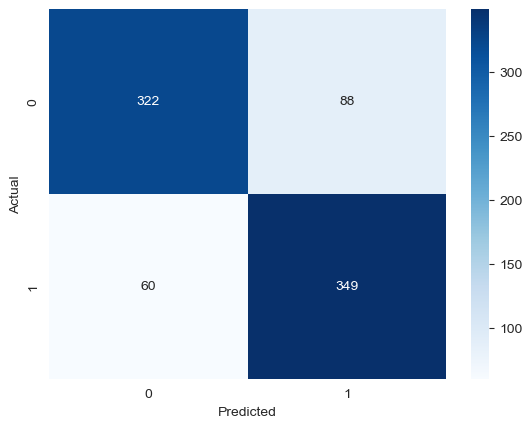

In [185]:
testing(y_test,y_pred)

#### Random Forest Classifier

In [186]:
from sklearn.ensemble import RandomForestClassifier

In [190]:
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)  # You can adjust the number of trees (n_estimators)
rf_classifier.fit(X_train, y_train)
y_pred = rf_classifier.predict(X_test)

Accuracy: 0.8705738705738706
Classification Report:
               precision    recall  f1-score   support

         0.0       0.88      0.85      0.87       402
         1.0       0.86      0.89      0.87       417

    accuracy                           0.87       819
   macro avg       0.87      0.87      0.87       819
weighted avg       0.87      0.87      0.87       819


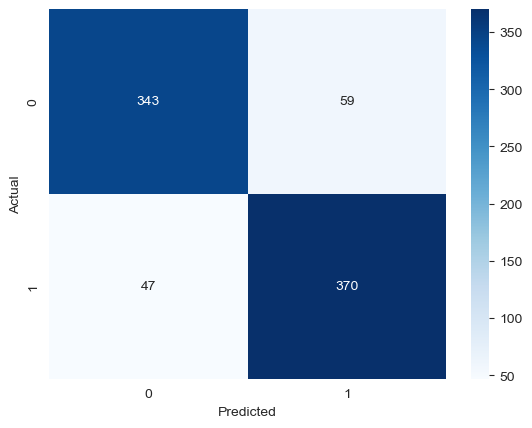

In [191]:
testing(y_test,y_pred)

#### Support Vector Machines (SVM)

In [177]:
from sklearn.svm import SVC

In [178]:
svclassifier = SVC()
svclassifier.fit(X_train, y_train)
y_pred = svclassifier.predict(X_test)

Accuracy: 0.8681318681318682
Classification Report:
               precision    recall  f1-score   support

         0.0       0.85      0.90      0.87       402
         1.0       0.89      0.84      0.87       417

    accuracy                           0.87       819
   macro avg       0.87      0.87      0.87       819
weighted avg       0.87      0.87      0.87       819


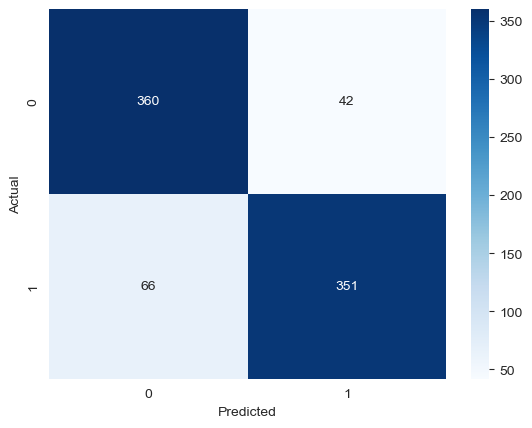

In [179]:
testing(y_test,y_pred)

#### Naive Bayes

##### GaussianNB

In [180]:
from sklearn.naive_bayes import GaussianNB

In [ ]:
gauss = GaussianNB()
gauss.fit(X_train, y_train)
y_pred = gauss.predict(X_test)

In [ ]:
testing(y_test,y_pred)

##### MultinomialNB

In [ ]:
from sklearn.naive_bayes import MultinomialNB

In [ ]:
mult = MultinomialNB()
mult.fit(X_train, y_train)
y_pred = mult.predict(X_test)

In [ ]:
testing(y_test,y_pred)

##### BernoulliNB

In [ ]:
from sklearn.naive_bayes import BernoulliNB
bern = BernoulliNB()
bern.fit(X_train, y_train)
y_pred = bern.predict(X_test)

In [ ]:
testing(y_test,y_pred)

#### Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
lregress = LogisticRegression()
lregress.fit(X_train, y_train)
y_pred = lregress.predict(X_test)

In [ ]:
testing(y_test,y_pred)

#### XGBoost/LightGBM (Gradient Boosting)

##### XGBoost

In [ ]:
import xgboost as xgb

In [ ]:
model = xgb.XGBClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)


In [ ]:
testing(y_test,y_pred)

##### LightGBM

In [ ]:
import lightgbm as lgb

In [ ]:
model = lgb.LGBMClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [ ]:
testing(y_test,y_pred)